# faiss-cpu 

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pickle # <-- 这个一定要学会
import cv2 as cv
import matplotlib.pyplot as plt
import time
from os.path import exists
from imutils import paths # 使用这个
import os
import faiss
from sklearn.decomposition import PCA

############################## 函数声明部分 ##############################
# 显示进度条
def progress_bar(s,i):
    print("\r", end="")  # 输出位置回到行首
    print(s+": {}%: ".format(i), "▋" * (i // 2), end="") 

# 把图像转化成指定长度的特征向量
def createImageFeatures(image, size=(32, 32)):
    image = cv.resize(image, size)
    pixel_list = image.flatten()
    return pixel_list

# 获取/创建包含有所有图像的X和y
def createXY(folder):
    if exists("X") and exists("y"):
        with open("X", 'rb') as f:
            X = pickle.load(f)
        with open("y", 'rb') as f:
            y = pickle.load(f)
        return X,y

    print("读取所有图像，生成X和y")
    image_paths = list(paths.list_images(folder)) #从folder中获得所有的图像文件列表

    X = []
    y = []
    i=1
    for image_path in image_paths:
        progress_bar("读取图像",i*100//len(image_paths))
        image = cv.imread(image_path, 0)
        label = image_path.split(os.path.sep)[-1].split(".")[0]
        if label=='dog':
            label=1
        else:
            label=0
        pixels = createImageFeatures(image)
        X.append(pixels)
        y.append(label)
        i=i+1
        
    print("\nX.shape:",np.shape(X))
    with open("X", 'wb') as f:
        pickle.dump(X, f)

    print("y.shape:",np.shape(y))
    with open("y", 'wb') as f:
        pickle.dump(y, f) 
    
    #使用PCA降维
    X = PCA(0.5).fit_transform(X)
    return X,y

############################## 使用 faiss-cpu 实现的 KNN  ##############################
class FaissKNeighbors:
    def __init__(self, n_neighbors=5):
        self.index = None
        self.y = None
        self.k = n_neighbors

    def fit(self, X, y):
    # 把所有X中的数据放到IndexFlatL2索引对象中
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
    # 返回待测值的k个最近邻的距离排序矩阵和索引值排序矩阵
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices] # 获得所有最近邻的类别列表votes
    # 得到votes中出现次数最多的类别，即为X的类别
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

    def score(self, X, y):
        return np.mean(self.predict(X)==y)



成功读取X和y
X的形状: (25000, 1024)
y的形状: (25000,)
[1 0 1 ... 0 1 1]
已生成：X_train, 形状: (18750, 1024)
开始搜索最佳K:
已保存具有最大准确率knn


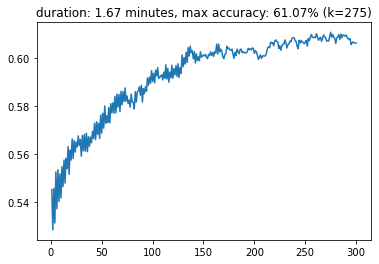

In [30]:
############################## 程序逻辑部分 ##############################
X,y = createXY(".")
X = np.array(X)
y = np.array(y) # 因为我的测试数据里的y是cat和dog的字符串，所以需要0和1
print("成功读取X和y")
print("X的形状:",X.shape)
print("y的形状:",y.shape)

# 2. 分割X和y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(y_test)
with open("X_train", 'wb') as f:
    pickle.dump(X_train,f)
    print("已生成：X_train, 形状:",np.shape(X_train))

# 3. 搜索最佳K
print("开始搜索最佳K:")
start = time.time() # <--- 开始计时
acc_list=[]
max_test=300
for k in range(1,max_test+1):
    clf = FaissKNeighbors(n_neighbors=k) # 1. 创建分类器
    clf.fit(X_train, y_train)                 # 2. fit
    acc = clf.score(X_test, y_test)           # 3. score
    #print("K={0} 准确率: {1:.2f}%".format(k, acc * 100))
    acc_list.append(acc) # 纪律所有的准确率
end = time.time() # <--- 结束计时

# 保存最大准确率对应的knn
max_acc_k=np.argmax(acc_list)+1 # 利用最大准确率的位置得到对应的k：max_acc_k
# 训练出 max_acc_k 对应的 knn 模型
clf = FaissKNeighbors(n_neighbors=max_acc_k).fit(X_train, y_train)
with open("knn", 'wb') as f: 
    pickle.dump(clf, f)
    print("已保存具有最大准确率knn")

# 保存测试结果到pdf
plt.plot(range(1,max_test+1),acc_list)
plt.title("duration: {0:.2f} minutes, max accuracy: {1:.2f}% (k={2})".format((end - start)/60,max(acc_list) * 100,max_acc_k))
plt.savefig("acc_{0}.pdf".format(max_test))